In this post I am going to talk about Customer Segmentation.<br>
An RFM based approach presented in these research papers, [1](https://www.sciencedirect.com/science/article/pii/S1319157818304178),[2](https://arxiv.org/ftp/arxiv/papers/2008/2008.08662.pdf).<br>

**RFM analysis**

Recency, frequency and monetary (RFM) analysis is a powerful and recognized technique in database marketing. It is widely used to rank the customers based on their prior purchasing history. RFM analysis finds use in a wide range of applications involving a large number of customers such as online purchase, retailing, etc. This method groups the customers based on three dimensions, recency(R), frequency (F) and monetary (M).

Recency – When was the last time the customer made a purchase?
Recency value is the number of days a customer takes between two purchases. A smaller value of recency implies that the customer visits the company repeatedly in a short period. Similarly, a greater value implies that the customer is less likely to visit the company shortly.

Frequency – How many times did the customer purchase?
Frequency is defined as the number of purchases a customer makes in a specific period. The higher the value of frequency the more loyal are the customers of the company.

Monetary – How much money did the customer spend?
Monetary is defined as the amount of money spent by the customer during a certain period. The higher the amount of money spent the more revenue they give to the company.
I am going to discuss some approaches on How to deal with retail data.

In [1]:
#Importing all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import random
seed=2022
random.seed(seed)


# Reading the Data.

In [2]:
retail = pd.read_csv('../input/online-retail-customer-clustering/OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**I will investigate as to what negative price and negative quantity means**, see if there is any information that our data can give us.

In [4]:
print(retail[retail['UnitPrice']<0].head(3),'\n\n')
print(retail[retail['UnitPrice']<0].describe())

       InvoiceNo StockCode      Description  Quantity       InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  12-08-2011 14:51   
299984   A563187         B  Adjust bad debt         1  12-08-2011 14:52   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom   


       Quantity  UnitPrice  CustomerID
count       2.0       2.00         0.0
mean        1.0  -11062.06         NaN
std         0.0       0.00         NaN
min         1.0  -11062.06         NaN
25%         1.0  -11062.06         NaN
50%         1.0  -11062.06         NaN
75%         1.0  -11062.06         NaN
max         1.0  -11062.06         NaN


We can see the description, **negative unitprice is just debt.**<br>
Also, there is no customerid associated with negative prices.
Now, I will check what negative quantity means.

What does 0 unit price mean?

In [5]:
retail[retail['UnitPrice']==0].describe()

,Quantity,UnitPrice,CustomerID
count,2515.000000,2515.0,40.000000
mean,-53.421074,0.0,14217.225000
std,540.206783,0.0,1676.321178
min,-9600.000000,0.0,12415.000000
25%,-32.000000,0.0,12722.750000
50%,-1.000000,0.0,13985.000000
75%,3.000000,0.0,15225.500000
max,12540.000000,0.0,18059.000000


When UnitPrice is 0, the mean of quantity is negative, std is very high. It could mean discount or free items.

In [6]:
retail[retail['Quantity']<=0][0:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom


I can see that negative quantity means discount or it could also be a free promotional item.<br>
I am going to remove the transactions with either negative quantity or unitprice less than or equal to zero.<br>
If I keep values with unitprice less than or equal to zero, this will increase the frequency of transactions of a customer when in reality the product was given as a promotion<br>
After that, I will take a look at remaining null values.

In [7]:
retail=retail[(retail['Quantity']>0) & (retail['UnitPrice']>0) ]
print(retail.isnull().sum())

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64


A lot of null CustomerIDs, let's see if there are any ways if we can get some of these back, as for the Description, we do not need this column for our clustering so I am going to remove this.

In [8]:
retail[(retail.CustomerID.isnull())].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,01-12-2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,01-12-2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,01-12-2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,01-12-2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,01-12-2010 14:32,1.66,NaN,United Kingdom


Let us see if Invoice numbers can give us some CustomerIDs back. One way of doing that would be getting invoice numbers of all null customerids and see if that invoice number has any customerid in the whole dataset as every two different customers can not have the same invoice number.

In [9]:
x=retail[(retail.CustomerID.isnull())].InvoiceNo.unique() #get all the unique invoice numbers where customer
print(len(x))
response=0
for i in x:
    if len(retail[   (retail.CustomerID.notnull()) & (retail.InvoiceNo==i)    ]['CustomerID'])>0: 
        response+=1
print(response)

1428
0


Looks like there are no invoice numbers that can give us any customerids back. We have no alternative but to remove all the rows with null customer ids.

In [10]:

retail=retail.dropna() #Dropping all the rows with null customer ids

In [11]:
retail['Amount']=retail['Quantity']*retail['UnitPrice'] # Creating 'Amount' column to see total transaction amount

After getting the Amount column, we can get monetary data (total of all the transactions of a customer).

In [12]:
data_monetary=retail.groupby('CustomerID')['Amount'].sum()
data_monetary=data_monetary.reset_index()
data_monetary=data_monetary.rename(columns={'Amount':'Monetary'})
data_monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


(array([3.54005614e-05, 1.48085081e-07, 7.40425407e-08, 8.22694896e-09,
        1.64538979e-08, 8.22694896e-09, 1.64538979e-08, 0.00000000e+00,
        0.00000000e+00, 1.64538979e-08]),
 array([3.75000000e+00, 2.80239770e+04, 5.60442040e+04, 8.40644310e+04,
        1.12084658e+05, 1.40104885e+05, 1.68125112e+05, 1.96145339e+05,
        2.24165566e+05, 2.52185793e+05, 2.80206020e+05]),
 <BarContainer object of 10 artists>)

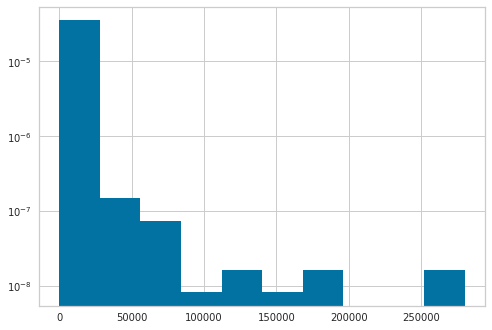

In [13]:
plt.hist(data_monetary['Monetary'],bins=10,density=True,log=True)

Looks like the distribution is skewed and there could be some outliers. I will investigate later. <br>
Next step is to get frequency data, it tells us how frequent a customer is with transactions. Frequency can be easily calculated using the number of Invoices generated for a particular customer.


In [14]:
data_frequency=retail.groupby('CustomerID')['InvoiceNo'].count()
data_frequency=data_frequency.reset_index()
data_frequency=data_frequency.rename(columns={'InvoiceNo':'Frequency'})
data_frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


(array([1.26601439e-03, 5.58233313e-06, 1.17522803e-06, 5.87614013e-07,
        0.00000000e+00, 2.93807007e-07, 2.93807007e-07, 2.93807007e-07,
        0.00000000e+00, 2.93807007e-07]),
 array([1.0000e+00, 7.8560e+02, 1.5702e+03, 2.3548e+03, 3.1394e+03,
        3.9240e+03, 4.7086e+03, 5.4932e+03, 6.2778e+03, 7.0624e+03,
        7.8470e+03]),
 <BarContainer object of 10 artists>)

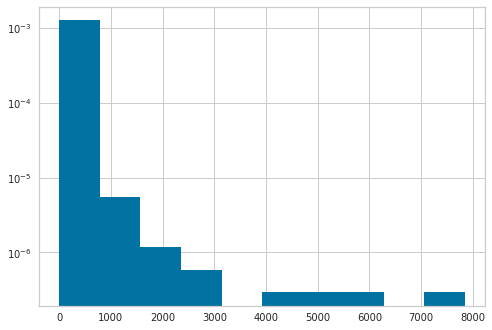

In [15]:
plt.hist(data_frequency['Frequency'],bins=10,density=True,log=True)

Again, the frequencies are also skewed. Let's check if there is a correlation between frequency and Amount spent.

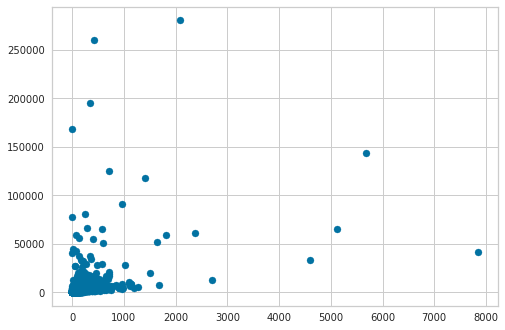

In [16]:
plt.scatter(data_frequency.Frequency,data_monetary['Monetary'])

There is some linear correlation between both but as the we move towards extreme ends of both sides.<br> We will have a look as to why this is happening later on.<br>
Our next target is geting Recency data, recency means how many days has it been since the customer has made a transaction with us. For recency calculation, we are provided with date and time, we can get the latest date of transaction of a customer and subtract all dates from it.

In [17]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date=max(retail['InvoiceDate'])
retail['Recency']=max_date-retail['InvoiceDate']
data_recency=retail.groupby('CustomerID')['Recency'].min()
data_recency=data_recency.reset_index()
data_recency['Recency']=data_recency['Recency'].dt.days
data_recency.head(5)

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


(array([0.01168055, 0.00498741, 0.00224341, 0.0014647 , 0.00139054,
        0.00117424, 0.00117424, 0.00103827, 0.00087141, 0.00078488]),
 array([  0. ,  37.3,  74.6, 111.9, 149.2, 186.5, 223.8, 261.1, 298.4,
        335.7, 373. ]),
 <BarContainer object of 10 artists>)

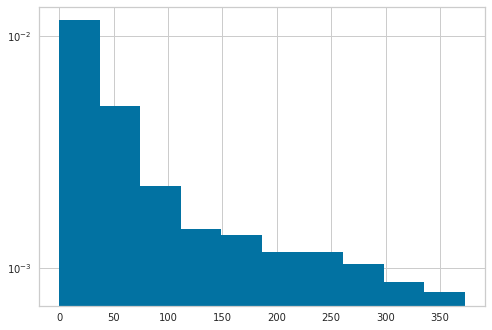

In [18]:
plt.hist(data_recency['Recency'],bins=10,density=True,log=True)

# After having all the data for Recency, Frequency and Monetary we can further investiage our previous findings.

Looking at the distributions, all of them are skewed, it will not be easy to detect outliers (if any), in cases like these, using methods like bootstrapping can give powerful results. 
Methods like IQRs are not consistent if the distributions are not normal.<br>

Bootstrapping is any method that employs sampling with replacement. We will use sampling with replacement repeatedly to generate many samples of transaction data and build a confidence interval around a sample statistic (e.g. the 99th percentile). The below code can be found[ here](https://suplari.com/calculating-outliers-spend-data-bootstrapping/) with a very nice explanation of what bootstrapping is.

In [19]:
# Using random bootstrapping we can see what xth percentiles in our data look like. 
def bootstrap_sample(amounts):
    return np.random.choice(amounts, len(amounts), replace=True)

def percentile(sample,percent):
     return np.percentile(sample, percent)

def bootstrap_confidence_interval(data,percent):
    """
    Creates list of 10000 xth percentile bootstrap replicates. 
    """
    bs_samples = np.empty(10000)
    
    for i in range(10000):
        bs_samples[i] = percentile(bootstrap_sample(data),percent)

    return bs_samples

# Outliers - How to determine what customers to consider as outliers?
If I have huge transactions, should I be considered an outlier, on the other hand, If I do not have  huge transactions, should I be counted as an outlier and removed from the dataset? Are outliers not important to a company?
[A better approach proposed in RFM ranking – An effective approach to customer segmentation](https://reader.elsevier.com/reader/sd/pii/S1319157818304178?token=FAFC078DC48D3C1A7822AC89EFFFF0E58E02D64BD5FA1041E13847FA0624ECBBFC8F31CB8982533B5131C6C955708018&originRegion=us-east-1&originCreation=20220124175059) research paper suggests to give a score to each customer depending their RFM values. 

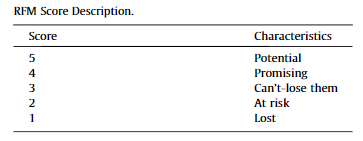

# I will try to replicate this approach and create a new dataset,  I will test kmeans on both my old and new dataset and  analyse the results.

In order to create RFM scores, we need to create qunatiles. Scores will be assigned to each customer based on quantiles.
If someone is above 80th percentile, they will have the highest score for frequency and monitary on the other hand if a customer is below 10th percentil, he will have the highest score because we want receny to be the lowest.

In [20]:
precentiles={
    'amount':[],
    'frequency':[],
    'recency':[]
    }
for i in [20,40,60,80]:
    precentiles['amount'].append(np.percentile(bootstrap_confidence_interval(data_monetary['Monetary'],i),95))
    precentiles['frequency'].append(np.percentile(bootstrap_confidence_interval(data_frequency['Frequency'],i),95))
    precentiles['recency'].append(np.percentile(bootstrap_confidence_interval(data_recency['Recency'],i),95))
precentiles

{'amount': [262.62, 510.71000000000004, 982.9699999999996, 2154.97],
 'frequency': [14.0, 30.0, 60.0, 127.0],
 'recency': [14.0, 34.0, 73.0, 185.0]}

In [21]:
#Merging all our dataframes to get final RFM data
df = data_frequency.merge(data_monetary, on='CustomerID', how='inner').merge(data_recency, on='CustomerID', how='inner')
df.head()

,CustomerID,Frequency,Monetary,Recency
0,12346.0,1,77183.60,325
1,12347.0,182,4310.00,1
2,12348.0,31,1797.24,74
3,12349.0,73,1757.55,18
4,12350.0,17,334.40,309


In this dataframe, I will add 3 new columns based on the scores for RFM.

In [22]:
# create a list of our conditions, more frequency is rated more.
conditions = [
    (df['Frequency'] <= precentiles['frequency'][0]),
    (df['Frequency'] > precentiles['frequency'][0]) & (df['Frequency'] <= precentiles['frequency'][1]) ,
    (df['Frequency'] > precentiles['frequency'][1]) & (df['Frequency'] <= precentiles['frequency'][2])  ,
    (df['Frequency'] > precentiles['frequency'][2]) & (df['Frequency'] <= precentiles['frequency'][3])  ,
    (df['Frequency'] > precentiles['frequency'][3])
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4,5]

# create a new column and use np.select to assign values to it using our lists as arguments
df['fscore'] = np.select(conditions, values)

# create a list of our conditions, recency is rated in the opposite order
conditions = [
    (df['Recency'] <= precentiles['recency'][0]),
    (df['Recency'] > precentiles['recency'][0]) & (df['Recency'] <= precentiles['recency'][1]) ,
    (df['Recency'] > precentiles['recency'][1]) & (df['Recency'] <= precentiles['recency'][2])  ,
    (df['Recency'] > precentiles['recency'][2]) & (df['Recency'] <= precentiles['recency'][3])  ,
    (df['Recency'] > precentiles['recency'][3])
    ]

# create a list of the values we want to assign for each condition
values = [5,4,3,2,1]

# create a new column and use np.select to assign values to it using our lists as arguments
df['rscore'] = np.select(conditions, values)


# create a list of our conditions, more Amount is rated more
conditions = [
    (df['Monetary'] <= precentiles['amount'][0]),
    (df['Monetary'] > precentiles['amount'][0]) & (df['Monetary'] <= precentiles['amount'][1]) ,
    (df['Monetary'] > precentiles['amount'][1]) & (df['Monetary'] <= precentiles['amount'][2])  ,
    (df['Monetary'] > precentiles['amount'][2]) & (df['Monetary'] <= precentiles['amount'][3])  ,
    (df['Monetary'] > precentiles['amount'][3])
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4,5]

# create a new column and use np.select to assign values to it using our lists as arguments
df['ascore'] = np.select(conditions, values)

df.head()

,CustomerID,Frequency,Monetary,Recency,fscore,rscore,ascore
0,12346.0,1,77183.60,325,1,1,5
1,12347.0,182,4310.00,1,5,5,5
2,12348.0,31,1797.24,74,3,2,4
3,12349.0,73,1757.55,18,4,4,4
4,12350.0,17,334.40,309,2,1,2


........................................................................

# Analysis without RFM scores

In [23]:
df1 = data_frequency.merge(data_monetary, on='CustomerID', how='inner').merge(data_recency, on='CustomerID', how='inner')
final_data_scaled=df1.drop(labels=['CustomerID'],axis=1)
final_data_scaled= (final_data_scaled-final_data_scaled.mean())/(final_data_scaled.std())
final_data_scaled.head(2)

,Frequency,Monetary,Recency
0,-0.396532,8.357705,2.334305
1,0.394603,0.250937,-0.905236


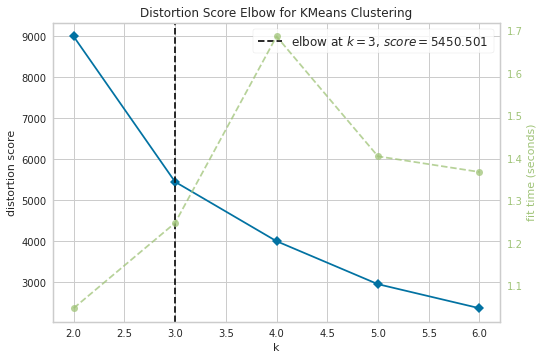

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,3,4,5,6))
visualizer.fit(final_data_scaled)        # Fit the data to the visualizer
visualizer.show() 

Elbow found at k=3, it means that 3 is the optimal number of clusters our elbow method has recommended.<br>
Let's do some silhouette analysis and see if elbow method and silhouette give same optimal values for k or not.

For n_clusters = 2 The average silhouette_score is : 0.9311835523719525
For n_clusters = 3 The average silhouette_score is : 0.6019775931686976
For n_clusters = 4 The average silhouette_score is : 0.6000318625764626
For n_clusters = 5 The average silhouette_score is : 0.6175378824132868
For n_clusters = 6 The average silhouette_score is : 0.5922769731235478


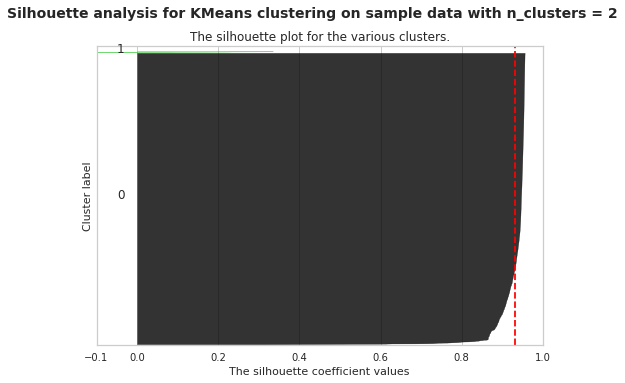

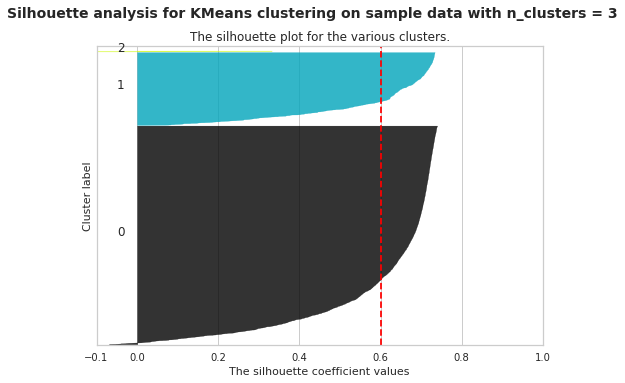

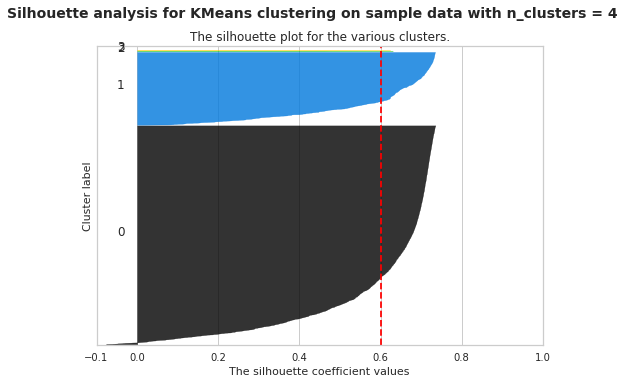

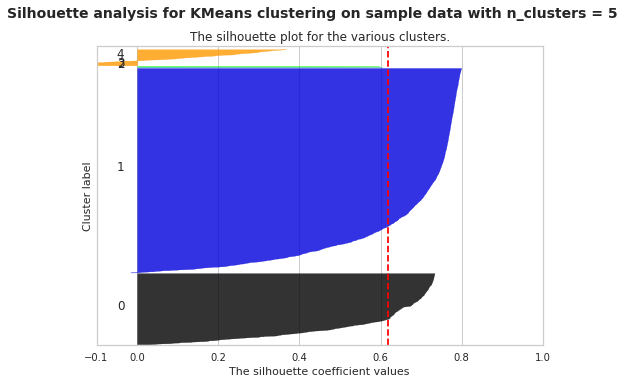

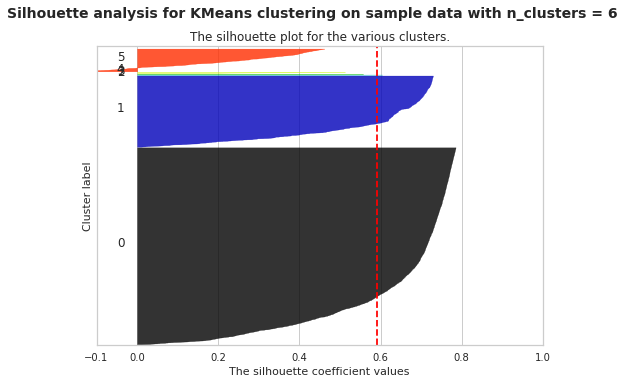

In [25]:
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()


    # The 1st subplot is the silhouette plot

    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([1, len(final_data_scaled) +100])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(final_data_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(final_data_scaled, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(final_data_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.8,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

We can see that at k=3, not all clusters are above avg score but at k =3,but our smallest cluster is further divided into 2 parts. Let us go with k=4 and see how the clusters look.

***How do the clusters look?***

Text(0.5, 0, 'Recency')

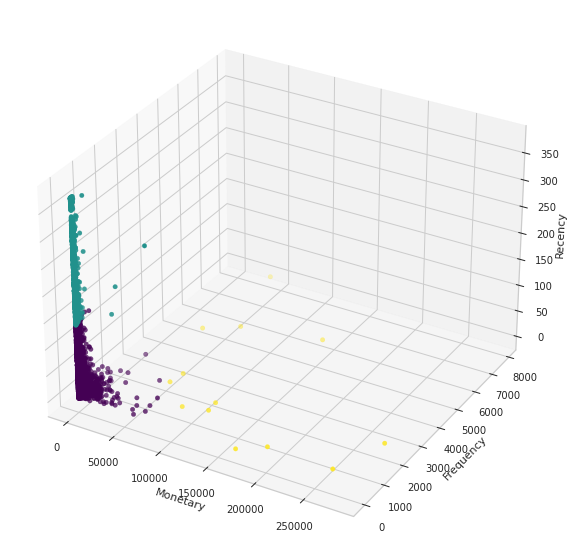

In [26]:
random.seed(2022)
model = KMeans(n_clusters=3, random_state=0).fit(final_data_scaled)
df1['labels']=model.labels_
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df1['Monetary'], df1['Frequency'],df1['Recency'],c=df1['labels'], cmap='viridis')
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

<AxesSubplot:xlabel='labels', ylabel='Recency'>

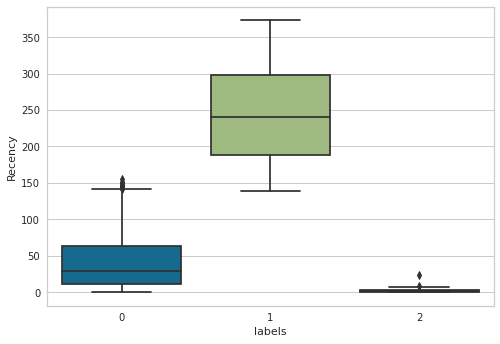

In [27]:
sns.boxplot(x=df1['labels'], y=df1['Recency'], data=df1)

# Trying the same approach with RFM scores dataframe

As we have a general idea that if frequency increases, amount spent also increases. So, I will take average of fscore and ascore and concatinate that score with recency score.
What it means is if a customer has a RFM score of 5 2 2, he will have a score of 54.

In [28]:
df["rfm"] = df['rscore'].astype(str) + ((df["fscore"] + (df["ascore"])/2).astype(int)).astype(str)

In [29]:
df=df.drop(labels=['fscore','rscore','ascore'],axis=1)
df['rfm']=df['rfm'].astype(int)
df.head(5)

,CustomerID,Frequency,Monetary,Recency,rfm
0,12346.0,1,77183.60,325,13
1,12347.0,182,4310.00,1,57
2,12348.0,31,1797.24,74,25
3,12349.0,73,1757.55,18,46
4,12350.0,17,334.40,309,13


In [30]:
# final_data_scaled_o is just my new dataframe with RFM score added  and then scaled.
final_data_scaled_o=df.drop(labels=['CustomerID'],axis=1)
final_data_scaled_o['Frequency']=(final_data_scaled_o['Frequency']-final_data_scaled_o['Frequency'].mean())/(final_data_scaled_o['Frequency'].std())
final_data_scaled_o['Monetary']=(final_data_scaled_o['Monetary']-final_data_scaled_o['Monetary'].mean())/(final_data_scaled_o['Monetary'].std())
final_data_scaled_o['Recency']=(final_data_scaled_o['Recency']-final_data_scaled_o['Recency'].mean())/(final_data_scaled_o['Recency'].std())
final_data_scaled_o

,Frequency,Monetary,Recency,rfm
0,-0.396532,8.357705,2.334305,13
1,0.394603,0.250937,-0.905236,57
2,-0.265405,-0.028593,-0.175339,25
3,-0.081826,-0.033008,-0.735260,46
4,-0.326597,-0.191325,2.174328,13
...,...,...,...,...
4333,-0.357194,-0.208435,1.854373,11
4334,-0.370307,-0.219535,0.884510,21
4335,-0.348452,-0.208718,-0.845244,51
4336,2.903508,0.004518,-0.885239,57


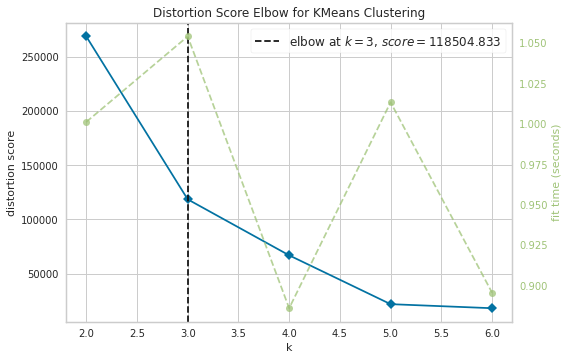

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
model1 = KMeans()
visualizer1 = KElbowVisualizer(model1, k=(2,3,4,5,6))
visualizer1.fit(final_data_scaled_o)        # Fit the data to the visualizer
visualizer1.show() 

For n_clusters = 2 The average silhouette_score is : 0.62383598427966
For n_clusters = 3 The average silhouette_score is : 0.5936816036954182
For n_clusters = 4 The average silhouette_score is : 0.6431040487251355
For n_clusters = 5 The average silhouette_score is : 0.7578545587211614
For n_clusters = 6 The average silhouette_score is : 0.7620689634820392
For n_clusters = 7 The average silhouette_score is : 0.7231603939826976
For n_clusters = 8 The average silhouette_score is : 0.675727948359262
For n_clusters = 9 The average silhouette_score is : 0.6640211566545818


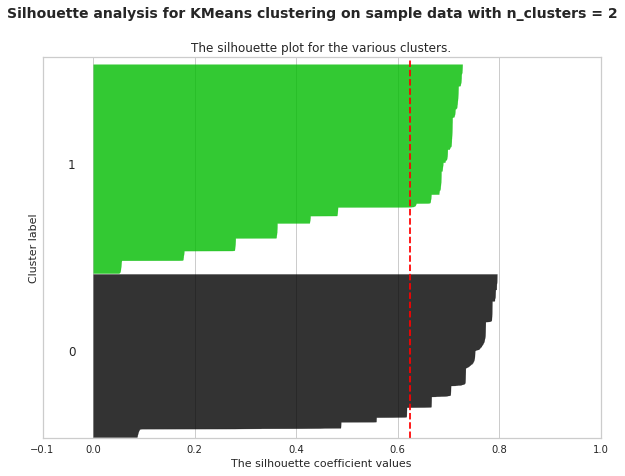

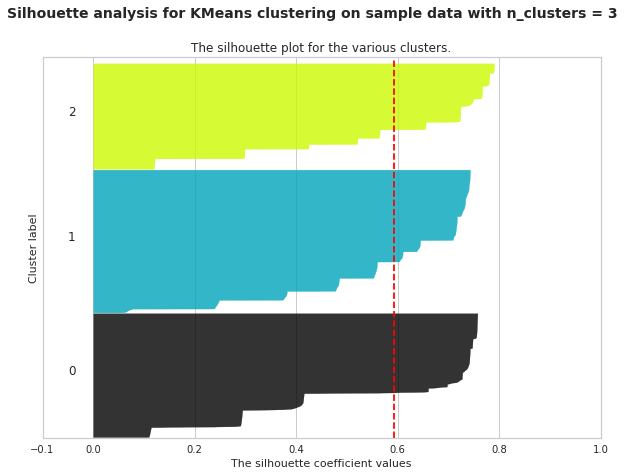

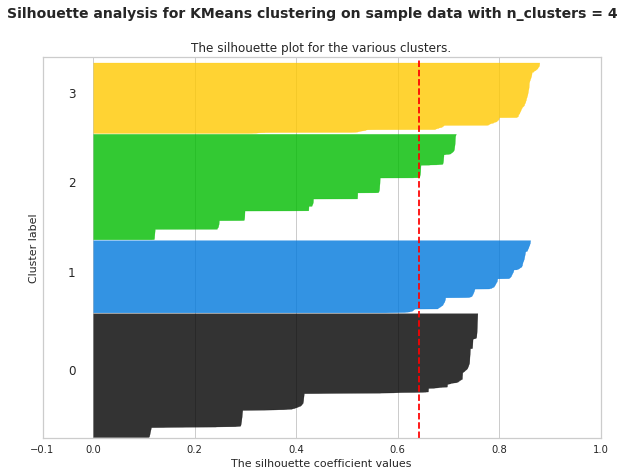

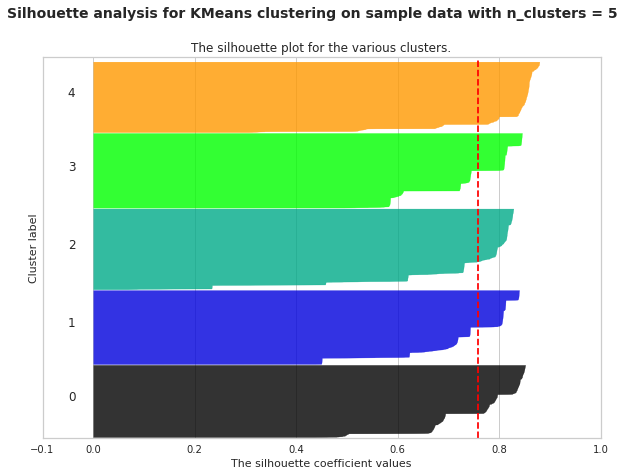

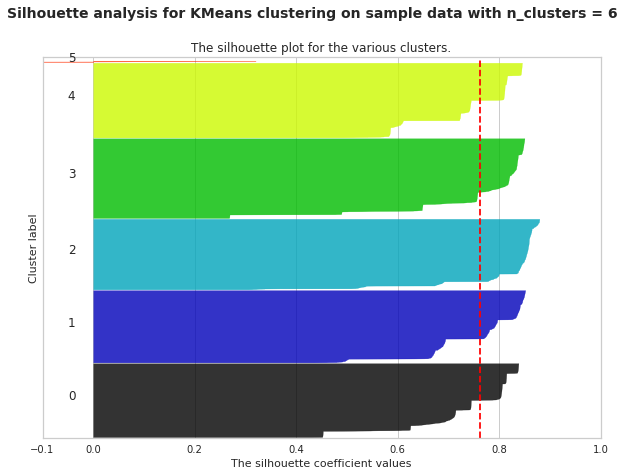

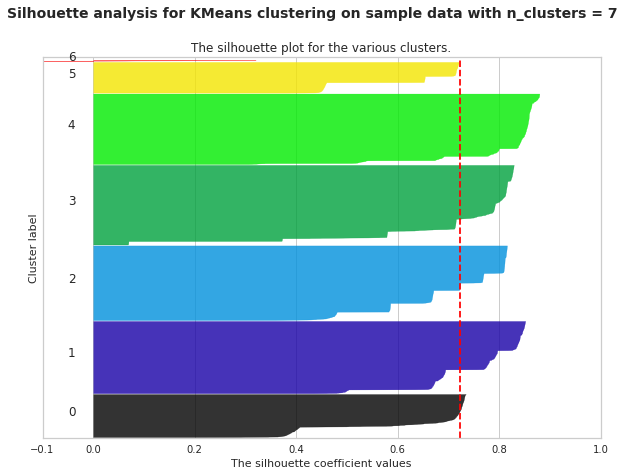

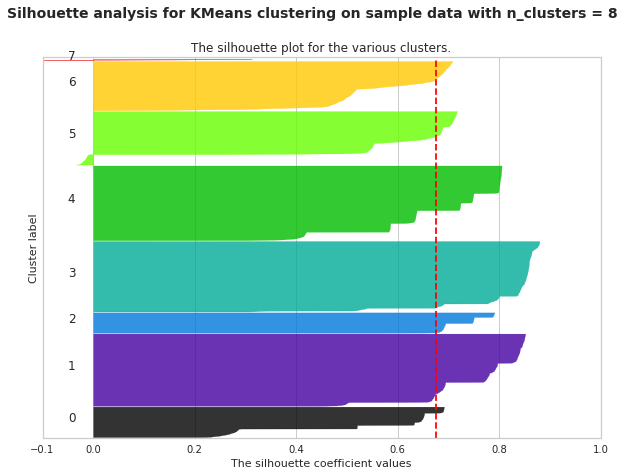

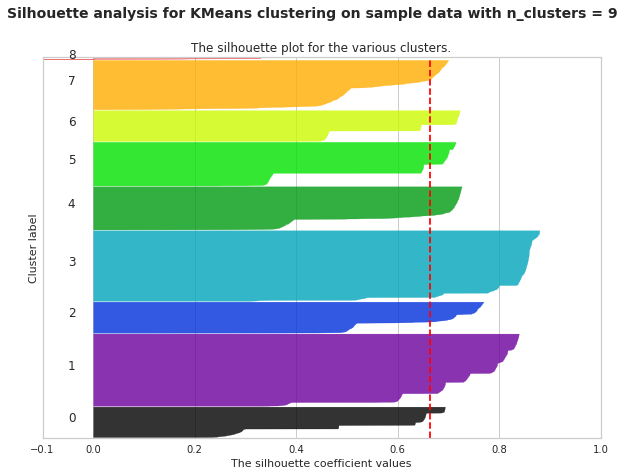

In [32]:
range_n_clusters = [2, 3, 4, 5, 6,7,8,9]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot

    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([1, len(final_data_scaled_o) +100])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(final_data_scaled_o)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(final_data_scaled_o, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(final_data_scaled_o, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.8,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Text(0.5, 0, 'Recency')

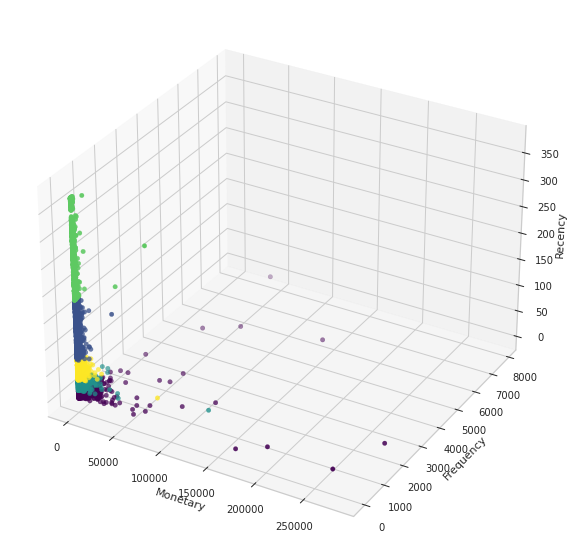

In [33]:
model2 = KMeans(n_clusters=5, random_state=seed).fit(final_data_scaled_o)
df['labels']=model2.labels_
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Monetary'], df['Frequency'],df['Recency'],c=df['labels'], cmap='viridis')
ax.set_xlabel('Monetary')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

<AxesSubplot:xlabel='labels', ylabel='Recency'>

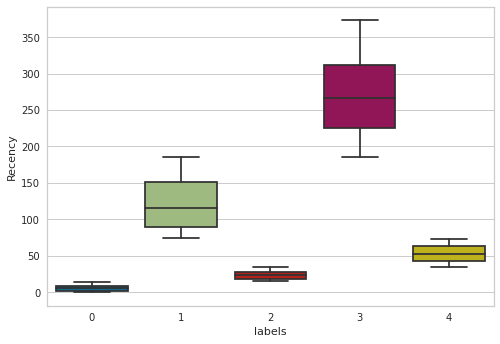

In [34]:
sns.boxplot(x=df['labels'], y=df['Recency'], data=df)

We can see from the plot above, Coustomers labeled 0,2,4 have fairly low recency while lables 1 and 3 means high recency.

<AxesSubplot:xlabel='labels', ylabel='Frequency'>

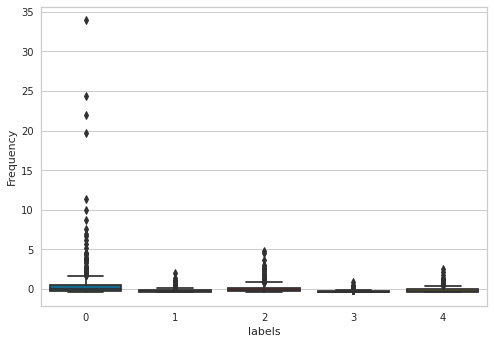

In [35]:
sns.boxplot(x=df['labels'], y=final_data_scaled_o['Frequency'], data=df)

<AxesSubplot:xlabel='labels', ylabel='Monetary'>

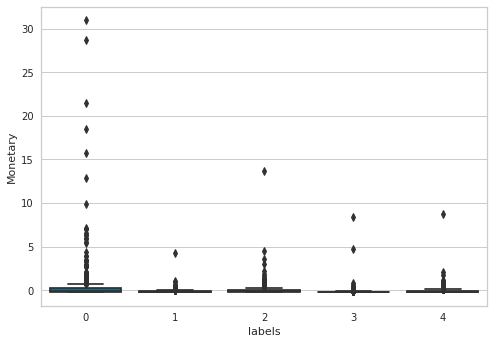

In [36]:
sns.boxplot(x=df['labels'], y=final_data_scaled_o['Monetary'], data=df)

# Label 3, Let us analyze people in this category.

In [37]:
print(df[df['labels']==3],'\n\n\n\n')
print(df[df['labels']==3].describe(),"\n\n")

print('Percentage of these customers',((df[df['labels']==3].shape[0])/df.shape[0])*100)

      CustomerID  Frequency  Monetary  Recency  rfm  labels
0        12346.0          1  77183.60      325   13       3
4        12350.0         17    334.40      309   13       3
6        12353.0          4     89.00      203   11       3
7        12354.0         58   1079.40      231   15       3
8        12355.0         13    459.40      213   12       3
...          ...        ...       ...      ...  ...     ...
4301     18233.0          1    440.00      325   12       3
4305     18239.0         88   1561.61      218   16       3
4313     18250.0         21    349.27      309   13       3
4325     18269.0          7    168.60      365   11       3
4333     18280.0         10    180.60      277   11       3

[822 rows x 6 columns] 




         CustomerID   Frequency      Monetary     Recency         rfm  labels
count    822.000000  822.000000    822.000000  822.000000  822.000000   822.0
mean   15314.118005   25.197080    607.934320  272.037713   12.559611     3.0
std     1730.4470

Recency range -186  to 373 <br>
Frequency Range - 1 to 297<br>
Monetary Range - 3.75 to 77183.60<br>

People in this caregory are the ones with mean Recency of 272, that means most of the people in this categoty are already lost. But there are still some people with minimum Recency of 186.<br>
Recency of 186 is okay, given the customers should have Frequency more than the average frequency of people here. Are there any such customers? Let us find out.

# Label 1

In [38]:
print(df[df['labels']==1].head(),'\n\n\n\n')
print(df[df['labels']==1].describe())
print('Percentage of these customers',((df[df['labels']==1].shape[0])/df.shape[0])*100)

    CustomerID  Frequency  Monetary  Recency  rfm  labels
2      12348.0         31   1797.24       74   25       1
16     12363.0         23    552.00      109   23       1
27     12378.0        219   4008.62      129   27       1
28     12379.0         40    852.24       81   24       1
31     12383.0         99   1850.56      184   26       1 




         CustomerID   Frequency      Monetary     Recency         rfm  labels
count    842.000000  842.000000    842.000000  842.000000  842.000000   842.0
mean   15288.213777   45.611639    911.908992  120.927553   23.546318     1.0
std     1733.005343   52.530881   1713.373621   34.263173    1.751742     0.0
min    12348.000000    1.000000     13.300000   74.000000   21.000000     1.0
25%    13780.250000   14.000000    292.037500   89.000000   22.000000     1.0
50%    15323.500000   29.000000    549.455000  115.500000   23.000000     1.0
75%    16804.000000   57.750000   1042.890000  151.000000   25.000000     1.0
max    18281.000000  54

Recency range - 74 to 185 <br>
Frequency Range - 1 to 543 <br>
Monetary Range - 13.0 to 39916 <br>
People in this segment are on **Risk** of being lost.

In [39]:
print(df[(df['labels']==3) & (df['Recency']<=120) & (df['Frequency']>45)],'\n\n')
print((df[(df['labels']==3) & (df['Recency']<=120) & (df['Frequency']>45)].shape[0]/df[df['labels']==3].shape[0])*100)

Empty DataFrame
Columns: [CustomerID, Frequency, Monetary, Recency, rfm, labels]
Index: [] 


0.0


As we can see, in this category, 20% percent customers in this cluster have recency of 115 days or less while average frequency of 45 or higher. This segment of customers are on the verge of being lost and could be saved because frequency and monetary numbers are good

# Label 4

In [40]:
print(df[df['labels']==4].head(),'\n\n\n\n')
print(df[df['labels']==4].describe())
print('Percentage of these customers',((df[df['labels']==4].shape[0])/df.shape[0])*100)

    CustomerID  Frequency  Monetary  Recency  rfm  labels
5      12352.0         85   2506.04       35   36       4
12     12359.0        248   6372.58       57   37       4
13     12360.0        129   2662.06       51   37       4
20     12370.0        167   3545.69       50   37       4
21     12371.0         63   1887.96       44   36       4 




         CustomerID   Frequency      Monetary     Recency         rfm  labels
count    871.000000  871.000000    871.000000  871.000000  871.000000   871.0
mean   15323.812859   65.835821   1285.428876   53.026406   34.070034     4.0
std     1682.108597   73.883020   3167.540454   11.524008    1.865207     0.0
min    12352.000000    1.000000      6.200000   35.000000   31.000000     4.0
25%    13875.500000   19.500000    332.470000   43.000000   33.000000     4.0
50%    15329.000000   40.000000    662.590000   52.000000   34.000000     4.0
75%    16691.500000   90.000000   1466.860000   63.000000   36.000000     4.0
max    18287.000000  66

Recency range - 35 to 73 <br>
Frequency Range 1 - to 660 <br>
Monetary Range - 6.2 to 81024 <br>
People in this cluster are labeled as **Can't lose them**. Recency is quite low, means of Frequency and Monetary are high, these customers can ve future potential loyal customers.

In [41]:
print((df[(df['labels']==4) & (df['Recency']<=53) & (df['Frequency']>65)].shape[0]/df[df['labels']==4].shape[0])*100)

19.747416762342134


In this segment 19% of people are have recency lower than 53 while frequency higher than 65.

# Label 2

In [42]:
print(df[df['labels']==2].head(),'\n\n\n\n')
print(df[df['labels']==2].describe())
print('Percentage of these customers',((df[df['labels']==2].shape[0])/df.shape[0])*100)

    CustomerID  Frequency  Monetary  Recency  rfm  labels
3      12349.0         73   1757.55       18   46       2
9      12356.0         59   2811.43       22   45       2
10     12357.0        131   6207.67       32   47       2
24     12374.0         33    742.93       24   44       2
29     12380.0        104   2724.81       21   46       2 




         CustomerID    Frequency       Monetary     Recency         rfm  \
count    862.000000   862.000000     862.000000  862.000000  862.000000   
mean   15294.598608   104.866589    1998.136904   23.168213   44.757541   
std     1717.750241   125.096031    5164.801195    5.575645    1.900035   
min    12349.000000     1.000000      20.800000   15.000000   41.000000   
25%    13816.250000    28.000000     429.127500   18.000000   43.000000   
50%    15409.000000    66.000000     979.785000   23.000000   45.000000   
75%    16765.750000   131.750000    2124.060000   28.000000   46.000000   
max    18274.000000  1204.000000  124914.530000

Recency range - 15 to 34 <br>
Frequency Range - 1 to 1204 <br>
Monetary Range - 20 to 124914 <br>
People in this cluster are very **Promising**, mean value for recency is 23, for frequency and monetary, mean values are 104 and 1998.

# Label 0

In [43]:
print(df[df['labels']==0].head(),'\n\n\n\n')
print(df[df['labels']==0].describe())
print('Percentage of these customers',((df[df['labels']==0].shape[0])/df.shape[0])*100)

    CustomerID  Frequency  Monetary  Recency  rfm  labels
1      12347.0        182   4310.00        1   57       0
11     12358.0         19   1168.06        1   54       0
15     12362.0        266   5226.23        2   57       0
17     12364.0         85   1313.10        7   56       0
19     12367.0         11    168.90        3   51       0 




         CustomerID    Frequency       Monetary     Recency         rfm  \
count    941.000000   941.000000     941.000000  941.000000  941.000000   
mean   15283.001063   203.006376    5102.928757    5.836344   55.475027   
std     1747.369938   447.181626   17746.122669    4.225656    1.740831   
min    12347.000000     1.000000      35.400000    0.000000   51.000000   
25%    13790.000000    45.000000     717.450000    2.000000   54.000000   
50%    15152.000000   106.000000    1736.400000    6.000000   56.000000   
75%    16885.000000   219.000000    3834.260000    9.000000   57.000000   
max    18283.000000  7847.000000  280206.020000

Recency range - 0 to 14<br>
Frequency Range - 1 to 7847<br>
Monetary Range - 35 to 28026<br>
These are considered as **loyal** customers with lowest values for recency and highest values for monetary and frequency.